In [1]:
# Python Script to Extract tweets of a 
# particular Hashtag using Tweepy and Pandas

# import modules
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import datetime
import tweepy
import json
import pandas as pd
import csv
import re #regular expression
from textblob import TextBlob
import string
import preprocessor as p
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')  

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sasha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sasha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# function to display data of each tweet
def printtweetdata(n, ith_tweet):
    print()
    print(f"Tweet {n}:")
    print(f"Username:{ith_tweet[0]}")
    print(f"Description:{ith_tweet[1]}")
    print(f"Location:{ith_tweet[2]}")
    print(f"Following Count:{ith_tweet[3]}")
    print(f"Follower Count:{ith_tweet[4]}")
    print(f"Total Tweets:{ith_tweet[5]}")
    print(f"Retweet Count:{ith_tweet[6]}")
    print(f"Tweet Text:{ith_tweet[7]}")
    print(f"Hashtags Used:{ith_tweet[8]}")
    print(f"Date:{ith_tweet[9]}")

In [3]:
#importer dansk som sprog
#pip install afinn
from afinn import Afinn
afinn = Afinn(language='da')

### Combining dataframes

In [159]:
df1=pd.read_csv('C:/Users/sasha/OneDrive/Uni/Stud.polit/7. Semester/Social Data Science/Eksamen/df1.csv')
df2=pd.read_csv('C:/Users/sasha/OneDrive/Uni/Stud.polit/7. Semester/Social Data Science/Eksamen/df2.csv')
df3=pd.read_csv('C:/Users/sasha/OneDrive/Uni/Stud.polit/7. Semester/Social Data Science/Eksamen/df3.csv')

obs = [df1, df2, df3]

data_set = pd.concat(obs)
data_set = data_set.reset_index(drop = True)


,Unnamed: 0,location,totaltweets,retweetcount,hashtags,date,Clean Text,Sentiment
0,0,NaN,34115,1,"['coronadk', 'dkmedier', 'dkpol', 'covid19dk']",2021-08-16 23:59:33,beder alle indberette dette tweet da det tyde...,-1.0
1,1,Pangaea,39951,17,"['Bornholm', 'sundpol', 'dkpol', 'COVID19dk']",2021-08-16 21:14:11,få din vaccination uden tidsbestilling der er...,0.0
2,2,København,231239,17,"['Bornholm', 'sundpol', 'dkpol', 'COVID19dk']",2021-08-16 16:41:45,få din vaccination uden tidsbestilling der er...,0.0
3,3,Nykøbing Sjælland,21549,17,"['Bornholm', 'sundpol', 'dkpol', 'COVID19dk']",2021-08-16 16:07:07,få din vaccination uden tidsbestilling der er...,0.0
4,4,"København, Danmark",21567,0,"['dkpol', 'COVID19dk']",2021-08-16 15:48:37,indsatsen i afghanistan har kostet danmark ...,0.0
...,...,...,...,...,...,...,...,...
2377,2570,NaN,273,0,"['grundlovsbrud', 'tilgrin', 'covid19dk', 'dkp...",2021-08-17 10:51:39,kommer der så også spørgeskemaer som fokuser...,-2.0
2378,2571,"Copenhagen, Denmark",173,0,"['BeskytBørneneModCovid19', 'SikreSkoler', 'Si...",2021-08-17 10:51:30,/ de advarer om at børn og unge vil rammes h...,-2.0
2379,2572,"Copenhagen, Denmark",173,0,"['BeskytBørneneModCovid19', 'SikreSkoler', 'Si...",2021-08-17 10:49:43,/ såsom ventilation co målere luftrensere ...,0.0
2380,2573,NaN,11789,0,"['BritishColumbia', 'Canada', 'don', 'wildfire...",2021-08-17 10:48:00,,0.0


### Cleaning the DataFrame

In [5]:
#https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python

In [160]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
         "]+", flags=re.UNICODE)

In [163]:
#Dropping collumns
data_set1 = data_set.drop(['Unnamed: 0','username', 'description', 'followers', 'following'], axis=1).reset_index(drop = True)

#Creating collumn for hashtags
data_set1['hashtags'] = data_set1['text'].apply(lambda x: re.findall(r'#(\w+)', x))

#Calling text column
tweets = data_set1['text'].values

In [166]:
import numpy as np
wnl = nltk.WordNetLemmatizer()

def clean_tweet(tweet):
    if type(tweet) == np.float64:
        return ""
    temp = tweet.lower()
    temp = re.sub("'", "", temp) 
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('[.,*?:]',' ', temp)
    temp = re.sub('\v', ' ', temp)
    temp = re.sub("[\\n]",' ', temp)
    temp = re.sub('1/n',' ', temp)
    temp = re.sub('2/n',' ', temp)
    temp = re.sub('3/n',' ', temp)
    temp = re.sub('4/n',' ', temp)
    temp = re.sub('5/n',' ', temp)
    temp = re.sub('6/n',' ', temp)
    temp = re.sub('7/n',' ', temp)
    temp = re.sub('8/n',' ', temp)
    temp = re.sub('-','', temp) 
    temp = re.sub('%','', temp) 
    temp = re.sub('["]','', temp)
    temp = re.sub("[']","", temp)
    temp = re.sub('[0-9]', ' ', temp)
    temp = re.sub('\+', ' ', temp)
   
    temp = emoji_pattern.sub(r'', temp)
    return temp

In [165]:
clean_data = [clean_tweet(tweets) for tweets in tweets]

c = str(clean_data) #converting the clean_data from a list to a string
a = c.replace("'", "")
b = a.replace(",", "")

AttributeError: 'DataFrame' object has no attribute 'lower'

In [10]:
#Remove danish stopWords
stopWords = set(stopwords.words('danish'))
sent_sw_removed = [i for i in nltk.word_tokenize(b.lower()) if i not in stopWords]

# Counter

In [11]:
from collections import Counter

tæl = Counter(sent_sw_removed).most_common()

In [12]:
counter_tabel=pd.DataFrame(tæl)
counter_tabel.columns = ['Ord', 'Antal']

counter_tabel

,Ord,Antal
0,covid,351
1,kan,306
2,så,224
3,vaccination,200
4,få,177
...,...,...
3902,wto,1
3903,tilsidesætt,1
3904,patenterne,1
3905,medicinalindustrien,1


# Sentiment Analysis

In [13]:
tweetser = [None for i in range(len(data_set1))]

score = [None for i in range(len(data_set1))]
for i in range(len(data_set1)):  
    tweetser[i] = clean_tweet(data_set1.text.values[i])
    score[i]= afinn.score(tweetser[i])
    
#count reetweets
#Counter(tweetser).most_common()

In [14]:
data_set1['Clean Text'] = tweetser
data_set1['Sentiment'] = score
final_set = data_set1.drop(['text'], axis=1).reset_index(drop = True)
final_set

,location,totaltweets,retweetcount,hashtags,date,Clean Text,Sentiment
0,NaN,34115,1,"[coronadk, dkmedier, dkpol, covid19dk]",2021-08-16 23:59:33,beder alle indberette dette tweet da det tyde...,-1.0
1,Pangaea,39951,17,"[Bornholm, sundpol, dkpol, COVID19dk]",2021-08-16 21:14:11,få din vaccination uden tidsbestilling der er...,0.0
2,København,231239,17,"[Bornholm, sundpol, dkpol, COVID19dk]",2021-08-16 16:41:45,få din vaccination uden tidsbestilling der er...,0.0
3,Nykøbing Sjælland,21549,17,"[Bornholm, sundpol, dkpol, COVID19dk]",2021-08-16 16:07:07,få din vaccination uden tidsbestilling der er...,0.0
4,"København, Danmark",21567,0,"[dkpol, COVID19dk]",2021-08-16 15:48:37,indsatsen i afghanistan har kostet danmark ...,0.0
...,...,...,...,...,...,...,...
1731,København,33254,28,"[dkpol, dkmedier, coronadk, covid19dk, sundpol...",2021-08-11 18:48:21,israels massevaccination stigning i hjert...,0.0
1732,Denmark,15616,28,"[dkpol, dkmedier, coronadk, covid19dk, sundpol...",2021-08-11 17:59:14,israels massevaccination stigning i hjert...,0.0
1733,"København, Danmark",12430,28,"[dkpol, dkmedier, coronadk, covid19dk, sundpol...",2021-08-11 17:50:59,israels massevaccination stigning i hjert...,0.0
1734,"Frederiksberg, Denmark",44893,0,"[dkpol, dkmedier, COVID19]",2021-08-10 19:29:12,jeg kan på det varmeste anbefale at læse ...,2.0


# Bar chart for final_set

In [ ]:
#Bruger nyt dataset med opdateret datoer. Så final_set er erstattet med data_set10

In [172]:
data_set2 = pd.read_csv('C:/Users/sasha/OneDrive/Uni/Stud.polit/7. Semester/Social Data Science/Eksamen/covid_tweets.csv')
data_set10 = data_set2.drop(['Unnamed: 0'], axis=1).reset_index(drop = True)


data_set10

,location,totaltweets,retweetcount,hashtags,date,Clean Text,Sentiment
0,NaN,34115,1,"['coronadk', 'dkmedier', 'dkpol', 'covid19dk']",2021-08-16 23:59:33,beder alle indberette dette tweet da det tyde...,-1.0
1,Pangaea,39951,17,"['Bornholm', 'sundpol', 'dkpol', 'COVID19dk']",2021-08-16 21:14:11,få din vaccination uden tidsbestilling der er...,0.0
2,København,231239,17,"['Bornholm', 'sundpol', 'dkpol', 'COVID19dk']",2021-08-16 16:41:45,få din vaccination uden tidsbestilling der er...,0.0
3,Nykøbing Sjælland,21549,17,"['Bornholm', 'sundpol', 'dkpol', 'COVID19dk']",2021-08-16 16:07:07,få din vaccination uden tidsbestilling der er...,0.0
4,"København, Danmark",21567,0,"['dkpol', 'COVID19dk']",2021-08-16 15:48:37,indsatsen i afghanistan har kostet danmark ...,0.0
...,...,...,...,...,...,...,...
2377,NaN,273,0,"['grundlovsbrud', 'tilgrin', 'covid19dk', 'dkp...",2021-08-17 10:51:39,kommer der så også spørgeskemaer som fokuser...,-2.0
2378,"Copenhagen, Denmark",173,0,"['BeskytBørneneModCovid19', 'SikreSkoler', 'Si...",2021-08-17 10:51:30,/ de advarer om at børn og unge vil rammes h...,-2.0
2379,"Copenhagen, Denmark",173,0,"['BeskytBørneneModCovid19', 'SikreSkoler', 'Si...",2021-08-17 10:49:43,/ såsom ventilation co målere luftrensere ...,0.0
2380,NaN,11789,0,"['BritishColumbia', 'Canada', 'don', 'wildfire...",2021-08-17 10:48:00,,0.0


In [178]:
#def. kolonner til graf
def Sentiment_neg (row):
   if row['Sentiment'] == -1 :
      return '-1'
   if row['Sentiment'] == -2 :
      return '-2'
   if row['Sentiment'] == -3 :
      return '-3'
   if row['Sentiment'] == -4 :
      return '-4'
   if row['Sentiment'] == -5 :
      return '-5'
   if row['Sentiment'] == -6 :
      return '-6'
   if row['Sentiment'] == -7 :
      return '-7'
   if row['Sentiment'] == -8 :
      return '-8'
   if row['Sentiment'] == -9 :
      return '-9'
   if row['Sentiment'] == -10 :
      return '-10'
   if row['Sentiment'] == -11 :
      return '-11'
   if row['Sentiment'] == -11 :
      return '-12'
   return np.nan

def Sentiment_pos (row):
   if row['Sentiment'] == 1 :
      return '1'
   if row['Sentiment'] == 2 :
      return '2'
   if row['Sentiment'] == 3 :
      return '3'
   if row['Sentiment'] == 4 :
      return '4'
   if row['Sentiment'] == 5 :
      return '5'
   if row['Sentiment'] == 6 :
      return '6'
   if row['Sentiment'] == 7 :
      return '7'
   if row['Sentiment'] == 8 :
      return '8'
   if row['Sentiment'] == 9 :
      return '1'
   return np.nan
    
def Sentiment_neu (row):    
    if row['Sentiment'] == 0 :
      return '0'
    return np.nan

data_set10['Sentiment_neg'] = data_set10.apply (lambda row: Sentiment_neg(row), axis=1)
data_set10['Sentiment_pos'] = data_set10.apply (lambda row: Sentiment_pos(row), axis=1)
data_set10['Sentiment_neu'] = data_set10.apply (lambda row: Sentiment_neu(row), axis=1)


#tæl rækker
data_set10.count()

#indsæt tal fra final_set.count() til at finde gennemsnit
avr_neg=657/2382
avr_neu=949/2382
avr_pos=773/2382

avr_neu


0.3984047019311503

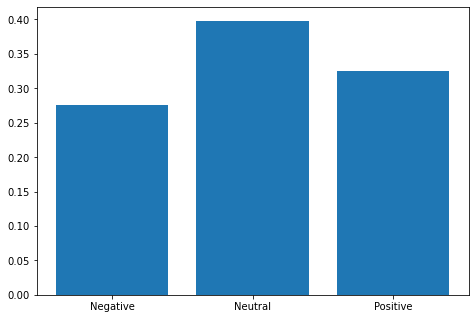

In [179]:
#plot graf
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Negative', 'Neutral', 'Positive']
andel = [0.27581863979848864,0.3984047019311503,0.3245172124265323]
ax.bar(langs,andel)
plt.show()

# Bar chart for dkpol

In [180]:
#nu til dkpol
dkpol=pd.read_csv('C:/Users/sasha/OneDrive/Uni/Stud.polit/7. Semester/Social Data Science/Eksamen/dkpol_final.csv')

In [181]:
dkpol

,location,totaltweets,retweetcount,hashtags,date,Clean Text,Sentiment
0,"Stevns, Danmark",1145,16,['dkpol'],2021-08-19 08:59:20,generation identitær påstod forleden i informa...,0.0
1,⚜️🇩🇰Denmark~Copenhagen Area,32740,0,['dkpol'],2021-08-19 08:58:27,når stat modtager flygtninger bærer den et s...,0.0
2,Danmark,23044,0,['dkpol'],2021-08-19 08:58:05,lige nu er populær på,3.0
3,Denmark,27829,0,['dkpol'],2021-08-19 08:57:39,og kan fortsat ikke blive enige politikern...,-3.0
4,"Aarhus, Danmark",838,9,"['croptop', 'dkmedier', 'dkpol']",2021-08-19 08:57:06,forbud mod croptops = negativ social kontrol ...,-4.0
...,...,...,...,...,...,...,...
3130,"Capital Region, Denmark",115,56,['dkpol'],2021-08-22 06:43:46,jeg fatter ikke at af danskerne støtter so...,3.0
3131,NaN,3751,2,"['adhd', 'autisme', 'cp', 'angst', 'skolevægri...",2021-08-22 06:43:04,jeg kommer til rødovre bibliotek / kl og...,0.0
3132,NaN,21479,11,['dkpol'],2021-08-22 06:42:34,i danmark skal vi leve af uddannelse både dem...,0.0
3133,NaN,12674,21,['dkpol'],2021-08-22 06:41:26,det håbløse er jo ikke kun som igen og igen v...,-6.0


In [187]:
#def. kolonner til graf
def Sentiment_neg_dkpol (row):
   if row['Sentiment'] == -1 :
      return '-1'
   if row['Sentiment'] == -2 :
      return '-2'
   if row['Sentiment'] == -3 :
      return '-3'
   if row['Sentiment'] == -4 :
      return '-4'
   if row['Sentiment'] == -5 :
      return '-5'
   if row['Sentiment'] == -6 :
      return '-6'
   if row['Sentiment'] == -7 :
      return '-7'
   if row['Sentiment'] == -8 :
      return '-8'
   if row['Sentiment'] == -9 :
      return '-9'
   if row['Sentiment'] == -10 :
      return '-10'
   if row['Sentiment'] == -11 :
      return '-11'
   if row['Sentiment'] == -11 :
      return '-12'
   return np.nan

def Sentiment_pos_dkpol (row):
   if row['Sentiment'] == 1 :
      return '1'
   if row['Sentiment'] == 2 :
      return '2'
   if row['Sentiment'] == 3 :
      return '3'
   if row['Sentiment'] == 4 :
      return '4'
   if row['Sentiment'] == 5 :
      return '5'
   if row['Sentiment'] == 6 :
      return '6'
   if row['Sentiment'] == 7 :
      return '7'
   if row['Sentiment'] == 8 :
      return '8'
   if row['Sentiment'] == 9 :
      return '1'
   return np.nan
    
def Sentiment_neu_dkpol (row):    
    if row['Sentiment'] == 0 :
      return '0'
    return np.nan

dkpol['Sentiment_neg_dkpol'] = dkpol.apply (lambda row: Sentiment_neg_dkpol(row), axis=1)
dkpol['Sentiment_pos_dkpol'] = dkpol.apply (lambda row: Sentiment_pos_dkpol(row), axis=1)
dkpol['Sentiment_neu_dkpol'] = dkpol.apply (lambda row: Sentiment_neu_dkpol(row), axis=1)


#tæl rækker
dkpol.count()

#indsæt tal fra dkpol.count() til at finde gennemsnit
avr_neg_dkpol=1120/3135
avr_neu_dkpol=797/3135
avr_pos_dkpol=1177/3135


avr_neu_dkpol

0.25422647527910686

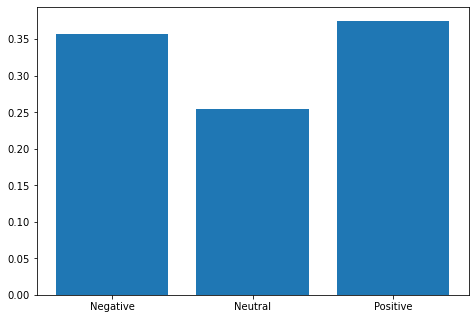

In [188]:
#plot graf for dkpol
figdkpol = plt.figure()
ax = figdkpol.add_axes([0,0,1,1])
langs = ['Negative', 'Neutral', 'Positive']
andel = [0.3572567783094099,0.25422647527910686,0.37543859649122807]
ax.bar(langs,andel)
plt.show()

In [191]:
data_set10[['Date', 'Time']] = data_set10.date.str.split(expand=True)

# Curve for final_set (pos, neg, neu), time series data

In [192]:

data_set10['sentiment_type'] = data_set10['Sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
data_set10['sentiment_type_count'] = data_set10['sentiment_type'].groupby(data_set10['Date']).transform('count')
df_sentiment_count = data_set10.sentiment_type.value_counts().rename_axis('types').reset_index(name='counts')
df_sentiment_count

,types,counts
0,Neutral,949
1,Positive,776
2,Negative,657


In [193]:
temps = data_set10[['sentiment_type', 'Date']]
df_daily_sentiment = temps.groupby(['Date', 'sentiment_type'])['sentiment_type'].count().reset_index(name='counts')
df_daily_sentiment

,Date,sentiment_type,counts
0,2021-08-09,Negative,32
1,2021-08-09,Neutral,40
2,2021-08-09,Positive,63
3,2021-08-10,Negative,49
4,2021-08-10,Neutral,69
5,2021-08-10,Positive,99
6,2021-08-11,Negative,64
7,2021-08-11,Neutral,91
8,2021-08-11,Positive,89
9,2021-08-12,Negative,80


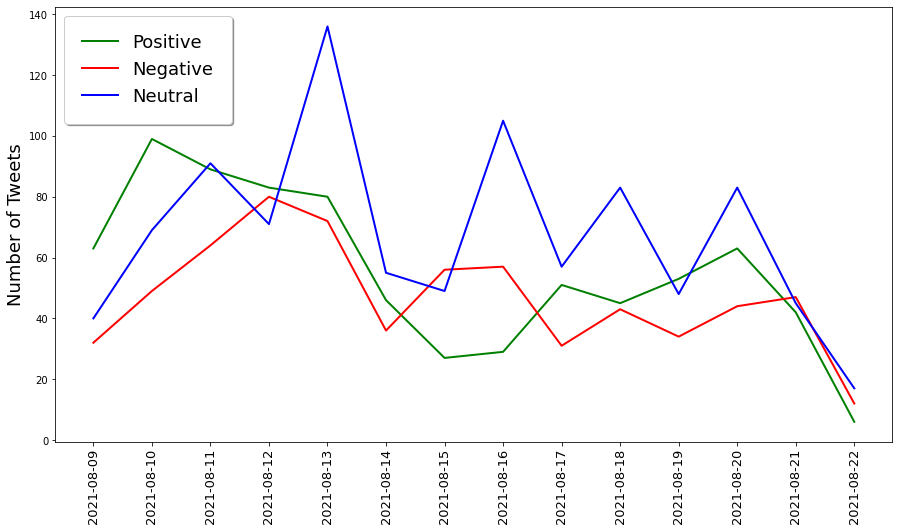

In [195]:
#plotting curve for final_set (positive, negative, neutral) on numbers of Tweets
positive = df_daily_sentiment[df_daily_sentiment['sentiment_type']=='Positive']
negative = df_daily_sentiment[df_daily_sentiment['sentiment_type']=='Negative']
neutral = df_daily_sentiment[df_daily_sentiment['sentiment_type']=='Neutral']

fig, ax = plt.subplots(figsize=(15,8))

plt.plot(positive['Date'], positive['counts'], color='green', linewidth = 2,  label = 'Positive')
plt.plot(negative['Date'], negative['counts'], color='red', linewidth = 2,  label = 'Negative')
plt.plot(neutral['Date'], neutral['counts'], color='blue', linewidth = 2,  label = 'Neutral')
plt.xlabel('', fontsize=18)
plt.ylabel('Number of Tweets', fontsize=18)
plt.title('')
plt.tick_params(axis='x', which='major', labelsize=13)
plt.legend(loc='upper left', fancybox=True, framealpha=1, shadow=True, borderpad=1, fontsize=18)
plt.xticks(rotation=90)
plt.show()

# Diagram for absolute values of Sentiment in final_set

In [199]:
#make a diagram for absolute 
sentiment_absolute=data_set10.groupby('Date', as_index=False).agg({"Sentiment": "count"})

t=pd.DataFrame(sentiment_absolute)
t

,Date,Sentiment
0,2021-08-09,135
1,2021-08-10,217
2,2021-08-11,244
3,2021-08-12,234
4,2021-08-13,288
5,2021-08-14,137
6,2021-08-15,132
7,2021-08-16,191
8,2021-08-17,139
9,2021-08-18,171


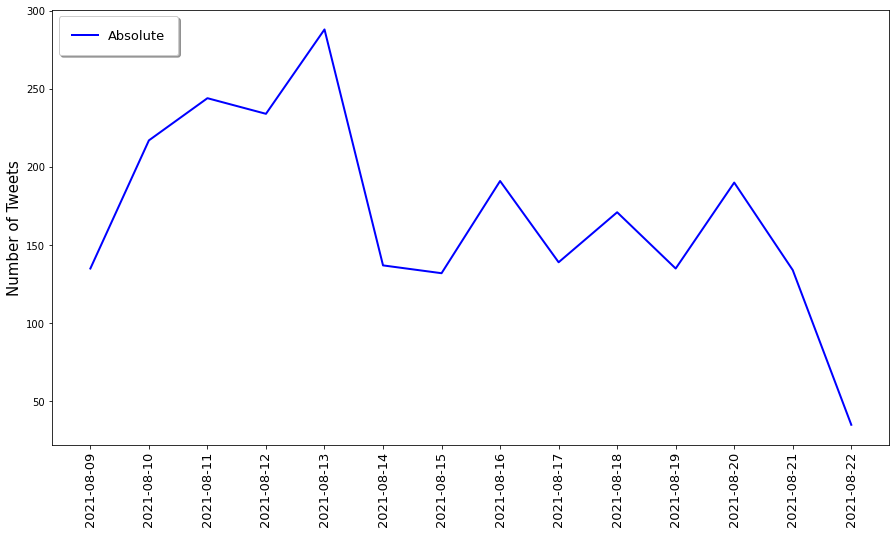

In [217]:
absolute = t[t['Sentiment']=='Sentiment']

fig, ax = plt.subplots(figsize=(15,8))

plt.plot(t['Date'], t['Sentiment'], color='blue', linewidth = 2,  label = 'Absolute')
plt.xlabel('', fontsize=18)
plt.ylabel('Number of Tweets', fontsize=15)
plt.title('')
plt.tick_params(axis='x', which='major', labelsize=13)
plt.legend(loc='upper left', fancybox=True, framealpha=1, shadow=True, borderpad=1, fontsize=13)
plt.xticks(rotation=90)
plt.show()

# Curve - ratio positive final_set/dkpol

In [202]:
rat = df_daily_sentiment.groupby(['Date'])['counts'].transform('sum')
rat

0     135
1     135
2     135
3     217
4     217
5     217
6     244
7     244
8     244
9     234
10    234
11    234
12    288
13    288
14    288
15    137
16    137
17    137
18    132
19    132
20    132
21    191
22    191
23    191
24    139
25    139
26    139
27    171
28    171
29    171
30    135
31    135
32    135
33    190
34    190
35    190
36    134
37    134
38    134
39     35
40     35
41     35
Name: counts, dtype: int64

In [203]:
df_daily_sentiment = df_daily_sentiment.assign(ratio=lambda x: x.counts.div(rat))
df_daily_sentiment

,Date,sentiment_type,counts,ratio
0,2021-08-09,Negative,32,0.237037
1,2021-08-09,Neutral,40,0.296296
2,2021-08-09,Positive,63,0.466667
3,2021-08-10,Negative,49,0.225806
4,2021-08-10,Neutral,69,0.317972
5,2021-08-10,Positive,99,0.456221
6,2021-08-11,Negative,64,0.262295
7,2021-08-11,Neutral,91,0.372951
8,2021-08-11,Positive,89,0.364754
9,2021-08-12,Negative,80,0.341880


In [204]:
total_final_set = df_daily_sentiment.pivot_table('ratio', index='sentiment_type', columns='Date', aggfunc=sum)
total_final_set

Positive_final_set=total_final_set.drop(['Negative', 'Neutral'], axis=0)
Positive_final_set

Date,2021-08-09,2021-08-10,2021-08-11,2021-08-12,2021-08-13,2021-08-14,2021-08-15,2021-08-16,2021-08-17,2021-08-18,2021-08-19,2021-08-20,2021-08-21,2021-08-22
sentiment_type,,,,,,,,,,,,,,
Positive,0.466667,0.456221,0.364754,0.354701,0.277778,0.335766,0.204545,0.151832,0.366906,0.263158,0.392593,0.331579,0.313433,0.171429


In [205]:
Positives_final_set=Positive_final_set.rename(index={"Positive": "Corona"})
Positives_final_set

Date,2021-08-09,2021-08-10,2021-08-11,2021-08-12,2021-08-13,2021-08-14,2021-08-15,2021-08-16,2021-08-17,2021-08-18,2021-08-19,2021-08-20,2021-08-21,2021-08-22
sentiment_type,,,,,,,,,,,,,,
Corona,0.466667,0.456221,0.364754,0.354701,0.277778,0.335766,0.204545,0.151832,0.366906,0.263158,0.392593,0.331579,0.313433,0.171429


In [206]:
#dkpol ratio positive

dkpol[['Date', 'Time']] = dkpol.date.str.split(expand=True)

dkpol['sentiment_type'] = dkpol['Sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
dkpol['sentiment_type_count'] = dkpol['sentiment_type'].groupby(final_set['Date']).transform('count')
dkpol_sentiment_count = dkpol.sentiment_type.value_counts().rename_axis('types').reset_index(name='counts')
dkpol_sentiment_count

tempser = dkpol[['sentiment_type', 'Date']]
dkpol_daily_sentiment = tempser.groupby(['Date', 'sentiment_type'])['sentiment_type'].count().reset_index(name='counts')
dkpol_daily_sentiment


dkpol_daily_sentiment = dkpol_daily_sentiment.assign(ratio=lambda x: x.counts.div(rat))
dkpol_daily_sentiment

rat = dkpol_daily_sentiment.groupby(['Date'])['counts'].transform('sum')
rat

dkpol_daily_sentiment = dkpol_daily_sentiment.assign(ratio=lambda x: x.counts.div(rat))
dkpol_daily_sentiment

total_dkpol = dkpol_daily_sentiment.pivot_table('ratio', index='sentiment_type', columns='Date', aggfunc=sum)
total_dkpol

Positive_dkpol=total_dkpol.drop(['Negative', 'Neutral'], axis=0)
Positive_dkpol



Date,2021-08-12,2021-08-13,2021-08-14,2021-08-15,2021-08-16,2021-08-17,2021-08-18,2021-08-19,2021-08-20,2021-08-21,2021-08-22
sentiment_type,,,,,,,,,,,
Positive,0.301754,0.414035,0.298246,0.389474,0.238596,0.361404,0.417544,0.42807,0.480702,0.417544,0.452632


In [207]:
total_corona = df_daily_sentiment.pivot_table('ratio', index='Date', columns='sentiment_type', aggfunc=sum)
total_corona

total_coronas=total_corona.rename(columns={"Positive": "Corona"})
total_coronas

sentiment_type,Negative,Neutral,Corona
Date,,,
2021-08-09,0.237037,0.296296,0.466667
2021-08-10,0.225806,0.317972,0.456221
2021-08-11,0.262295,0.372951,0.364754
2021-08-12,0.341880,0.303419,0.354701
2021-08-13,0.250000,0.472222,0.277778
2021-08-14,0.262774,0.401460,0.335766
2021-08-15,0.424242,0.371212,0.204545
2021-08-16,0.298429,0.549738,0.151832
2021-08-17,0.223022,0.410072,0.366906


In [208]:
total_graf_dkpol = dkpol_daily_sentiment.pivot_table('ratio', index='Date', columns='sentiment_type', aggfunc=sum)
total_graf_dkpol

total_graf_dkpols=total_graf_dkpol.rename(columns={"Positive": "dkpol"})
total_graf_dkpols

sentiment_type,Negative,Neutral,dkpol
Date,,,
2021-08-12,0.470175,0.228070,0.301754
2021-08-13,0.280702,0.305263,0.414035
2021-08-14,0.431579,0.270175,0.298246
2021-08-15,0.445614,0.164912,0.389474
2021-08-16,0.435088,0.326316,0.238596
2021-08-17,0.319298,0.319298,0.361404
2021-08-18,0.333333,0.249123,0.417544
2021-08-19,0.305263,0.266667,0.428070
2021-08-20,0.294737,0.224561,0.480702


In [224]:
#merge total_graf_dkpol and total_corona together
result = pd.concat([ total_coronas, total_graf_dkpols], axis=1)

result

#delete first three rows
ven=result.iloc[3:]

ven

#find correlation coefficient
np.corrcoef(ven["Corona"],ven["dkpol"])
#= 0.14099299, between "no linear" and "weak"

array([[1.        , 0.14099299],
       [0.14099299, 1.        ]])

Text(0.5, 0, '')

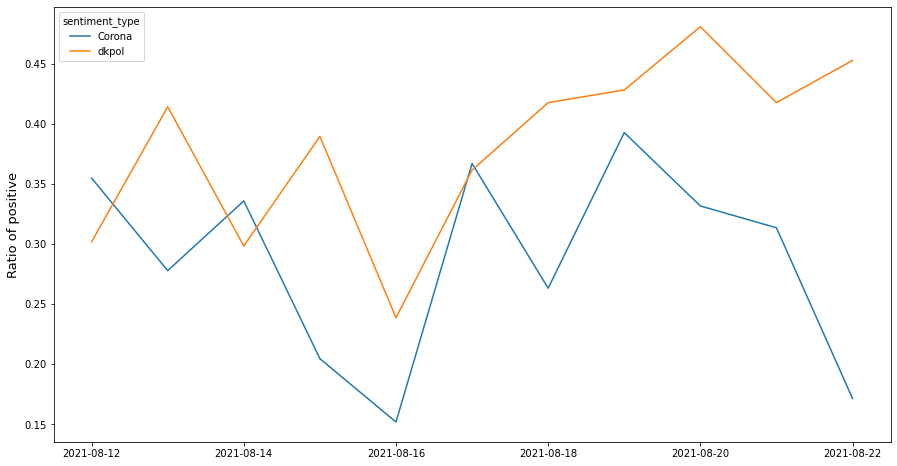

In [225]:
total = ven.drop(['Negative', 'Neutral'], axis=1).plot(figsize=(15,8))
#plt.xlabel('Year', fontsize=15)
plt.ylabel('Ratio of positive', fontsize=13)
plt.xlabel('', fontsize=13)



# Infection rates

In [213]:
#Making a dataframe of the infection rate in DK
df_ir=pd.read_csv('C:/Users/sasha/OneDrive/Uni/Stud.polit/7. Semester/Social Data Science/Eksamen/positives.csv')
data_ir = df_ir.reset_index(drop = True)
data_ir

,Date,NewPositive
0,8/9/2021,1082
1,8/10/2021,1066
2,8/11/2021,989
3,8/12/2021,1000
4,8/13/2021,963
5,8/14/2021,821
6,8/15/2021,935
7,8/16/2021,1100
8,8/17/2021,1028
9,8/18/2021,969


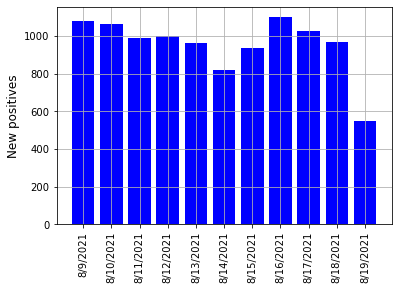

In [212]:
import matplotlib.pyplot as plt
import pandas as pd
   
New_Colors = ['blue']
#plt.figure(figsize=(15,4))
plt.bar(data_ir['Date'], data_ir['NewPositive'], color=New_Colors)
#plt.title('Infection rates in DK', fontsize=14)
#plt.xlabel('Date', fontsize=14)
plt.ylabel('New positives', fontsize=12)
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

#https://datatofish.com/bar-chart-python-matplotlib/

# Time series diagram - Stacked ratio chart on corona data

In [214]:
total_corona["dato"]=range(len(total_corona))
total_corona

sentiment_type,Negative,Neutral,Positive,dato
Date,,,,
2021-08-09,0.237037,0.296296,0.466667,0
2021-08-10,0.225806,0.317972,0.456221,1
2021-08-11,0.262295,0.372951,0.364754,2
2021-08-12,0.341880,0.303419,0.354701,3
2021-08-13,0.250000,0.472222,0.277778,4
2021-08-14,0.262774,0.401460,0.335766,5
2021-08-15,0.424242,0.371212,0.204545,6
2021-08-16,0.298429,0.549738,0.151832,7
2021-08-17,0.223022,0.410072,0.366906,8


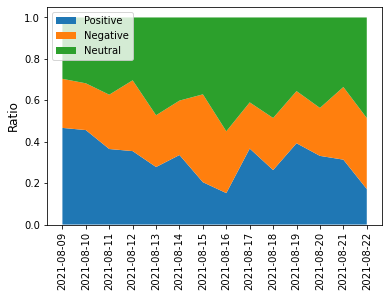

In [215]:
x=total_corona.index
y1=total_corona["Positive"]
y2=total_corona["Negative"]
y3=total_corona["Neutral"]
 
# Basic stacked area chart.
plt.stackplot(x,y1, y2, y3, labels=['Positive','Negative','Neutral'])
plt.legend(loc='upper left')
plt.ylabel('Ratio', size=12)
plt.xticks(rotation=90)
plt.show()


